## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import minkowski, cosine
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer


### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm="brute", metric="minkowski"):
        self._n_neighbors = n_neighbors
        self._algo = algorithm
        self._metric = metric

    def fit(self, X, y):
        # в sklearn.neighbors.KNeighborsClassifier по умолчанию используется метрика minkowski (p=2)
        self._data = X
        self._labels = y
        if self._algo == "kd_tree":
            self.tree = KDTree(X, metric=self._metric)

    def indices_reduce(self, temp):
        def my_func(arr):
            unique, unique_cnt = np.unique(arr, return_counts=True, axis=0)
            return unique[np.argmax(unique_cnt)]

        return np.apply_along_axis(my_func, 1, temp)

    # def calc_distances(self, arr_A, arr_B):
    # def func(temp_arr_B):
    # def sub_func(temp_arr_A):
    # if self._metric == "minkowski":
    # return minkowski(temp_arr_A, temp_arr_B)
    # else:
    # return cosine(temp_arr_A, temp_arr_B)

    # return np.apply_along_axis(sub_func, 1, arr_A)

    # return np.apply_along_axis(func, 1, arr_B)

    def predict(self, X):
        if self._algo == "brute":
            axis = 1
            ext_labels = cdist(X, self._data, self._metric)

            ind = np.arange(-1, -self._n_neighbors - 1, -1)
            final_indexes = np.take(
                np.argsort(-ext_labels, axis=axis), axis=axis, indices=ind
            )
        elif self._algo == "kd_tree":
            final_indexes = self.tree.query(
                X, k=self._n_neighbors, return_distance=False
            )
        temp = self._labels[final_indexes]
        return self.indices_reduce(temp)


In [3]:
# small brute test sample
X_t = np.asarray([[5], [6], [7], [-5], [-6], [-7]])
y_t = np.asarray([0, 0, 0, 1, 1, 1])
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm="brute")
my_clf.fit(X_t, y_t)
X_tst = np.asarray([[5], [-6.3]])
my_clf_pred = my_clf.predict(X_tst)
assert np.all(my_clf_pred == np.asarray([0, 1]))
# print(my_clf_pred)


In [4]:
# small kd_tree test sample
X_t = np.asarray([[5], [6], [7], [-5], [-6], [-7]])
y_t = np.asarray([0, 0, 0, 1, 1, 1])
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm="kd_tree")
my_clf.fit(X_t, y_t)
X_tst = np.asarray([[5], [-6.3]])
my_clf_pred = my_clf.predict(X_tst)
assert np.all(my_clf_pred == np.asarray([0, 1]))


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [5]:
iris = datasets.load_iris()


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, stratify=iris.target
)
print("Train shape:", X_train.shape)


Train shape: (135, 4)


In [7]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm="brute")
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm="brute")


In [8]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)


In [9]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert (
    abs(
        accuracy_score(y_test, my_clf_pred)
        - accuracy_score(y_test, sklearn_pred)
    )
    < 0.005
), "Score must be simillar"


### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [10]:
# timeit measures average time for a number of loops, but it is too slow
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [11]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [12]:
%time clf.predict(X_test)

Wall time: 4 ms


array([1, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 1, 0])

In [13]:
%time my_clf.predict(X_test)

Wall time: 999 µs


array([1, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 1, 0])

In [14]:
# time profiling
# (using cycles instead of cdist took much more time,
# so I dicided to check if everything is allright with code)
%load_ext line_profiler
%lprun -f my_clf.predict my_clf.predict(X_test)

Timer unit: 1e-07 s

Total time: 0.004349 s
File: C:\Users\3EC2~1\AppData\Local\Temp/ipykernel_12120/2426154540.py
Function: predict at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                               def predict(self, X):
    34         1         36.0     36.0      0.1          if self._algo == "brute":
    35         1          7.0      7.0      0.0              axis = 1
    36         1       2124.0   2124.0      4.9              ext_labels = cdist(X, self._data, self._metric)
    37                                           
    38         1        101.0    101.0      0.2              ind = np.arange(-1, -self._n_neighbors - 1, -1)
    39         2        190.0     95.0      0.4              final_indexes = np.take(
    40         1        926.0    926.0      2.1                  np.argsort(-ext_labels, axis=axis), axis=axis, indices=ind
    41                                                       )
    42                 

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [15]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm="kd_tree")
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm="kd_tree")


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, stratify=iris.target
)


In [17]:
%time clf.fit(X_train, y_train)

Wall time: 1e+03 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [18]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [19]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2])

In [20]:
%time my_clf.predict(X_test)

Wall time: 965 µs


array([0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2])

In [21]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert (
    abs(
        accuracy_score(y_test, my_clf_pred)
        - accuracy_score(y_test, sklearn_pred)
    )
    < 0.005
), "Score must be simillar"


### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [22]:
newsgroups = fetch_20newsgroups(
    subset="train", remove=["headers", "footers", "quotes"]
)


In [23]:
data = newsgroups["data"]
target = newsgroups["target"]


Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [26]:
print(data[0:2])
print("Shape before vectorization:", len(data), len(data[0]))
# let's ignore words that are less frequent than 10% and more frequent than 90%
vectorizer = CountVectorizer(min_df=0.1, max_df=0.9)
data = vectorizer.fit_transform(data).toarray()
# print(data[0, 25775])
# array = data.toarray()
# data.dtype=np.int8
print("Shape after vectorization:", data.shape)
print(target.shape)


['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.', "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't ans

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

*Примечание: изменено в новой версии на sklearn.model_selection*
[Ссылка](https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation)

In [27]:
# using 3 folds KFold
kfold = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [28]:
def get_optimal_kvalue(data_vectorized, target, metric="minkowski"):
    """Returns accuracy score values for different number of neighbors"""
    mean_scores = np.zeros(shape=(3, 10))
    i = 0
    for train_index, test_index in kfold.split(data_vectorized):
        clf = MyKNeighborsClassifier(
            n_neighbors=1, algorithm="brute", metric=metric
        )
        scores = np.asarray([])
        clf.fit(data_vectorized[train_index], target[train_index])
        for n_neighbors in range(1, 11):
            clf._n_neighbors = n_neighbors
            pred = clf.predict(data_vectorized[test_index])
            cur_score = accuracy_score(target[test_index], pred)
            scores = np.append(scores, cur_score)
        print(f"Mean scores vector for current fold is {scores}")
        mean_scores[i] = scores
        i += 1
    return mean_scores


In [29]:
def plot_optimal_kvalue(data_vectorized, target, metric="minkowski"):
    arr_mean_scores = get_optimal_kvalue(data_vectorized, target, metric)
    mean_scores = np.mean(arr_mean_scores, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, 11),
        mean_scores,
        color="blue",
        linestyle="dashed",
        marker="o",
        markerfacecolor="red",
        markersize=10,
    )
    plt.title("Mean score vs. K Value")
    plt.xlabel("K")
    plt.ylabel("Mean score for 3 folds")
    print(
        "Maximum score:",
        max(mean_scores),
        f"at K = {np.argmax(mean_scores) + 1}",
    )


Mean scores vector for current fold is [0.14130435 0.12460233 0.12778367 0.13149523 0.13918346 0.13812301
 0.14793213 0.14422057 0.14448568 0.14978791]
Mean scores vector for current fold is [0.13524264 0.12012729 0.12490056 0.12171838 0.13285601 0.13736409
 0.14028109 0.14638027 0.14770618 0.14797136]
Mean scores vector for current fold is [0.141607   0.13365155 0.12490056 0.13391673 0.1315301  0.13099973
 0.13126492 0.13630337 0.13603819 0.13524264]
Maximum score: 0.14433397083789246 at K = 10


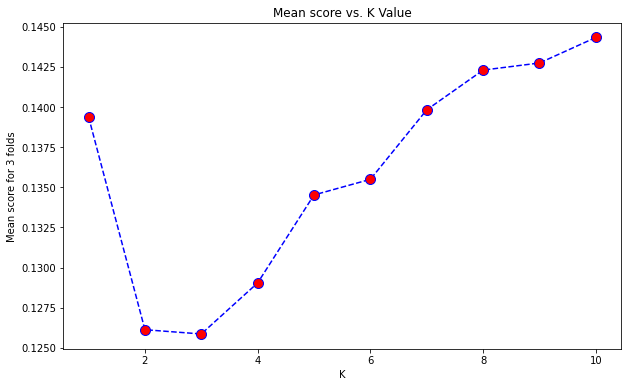

In [30]:
plot_optimal_kvalue(data, target)
# usually takes about 2,5 mins to compute with brute algorithm and about 2 mins with kd_tree 


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию(sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Mean scores vector for current fold is [0.05514316 0.05673383 0.05355249 0.05037116 0.04957582 0.04718982
 0.04984093 0.04957582 0.04825027 0.04559915]
Mean scores vector for current fold is [0.05383187 0.0548926  0.05648369 0.05303633 0.05171042 0.05144524
 0.05648369 0.05887033 0.05807478 0.0578096 ]
Mean scores vector for current fold is [0.05144524 0.05515778 0.05621851 0.05462742 0.05171042 0.05038451
 0.05409706 0.05038451 0.05277115 0.05224078]
Maximum score: 0.055594737573746326 at K = 2


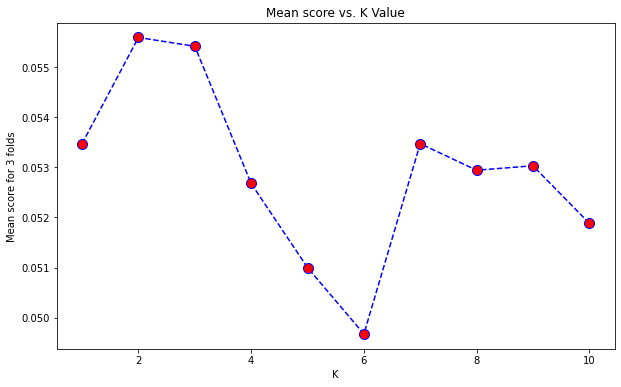

In [31]:
# 1. cosine metric
plot_optimal_kvalue(data, target, "cosine")


Mean scores vector for current fold is [0.1892895  0.17470838 0.16675504 0.16648993 0.17444327 0.17735949
 0.18292683 0.18319194 0.18239661 0.18372216]
Mean scores vector for current fold is [0.19146115 0.17873243 0.17767171 0.17475471 0.17555025 0.17608062
 0.17793689 0.17528507 0.17661098 0.17793689]
Mean scores vector for current fold is [0.17608062 0.16361708 0.1604349  0.1575179  0.15963935 0.1633519
 0.16865553 0.16945107 0.1705118  0.1675948 ]
Maximum score: 0.18561042256681778 at K = 1


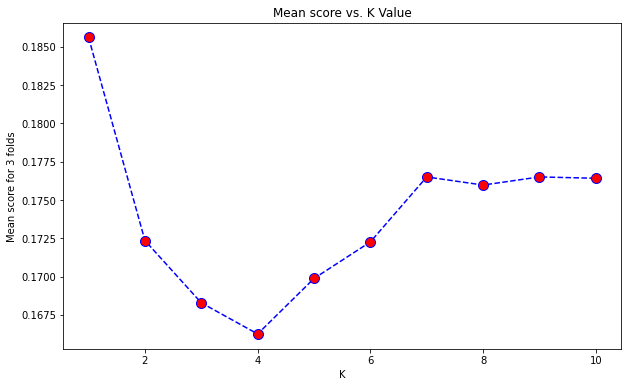

In [32]:
# 2. TfidfVectorizer (good results!)
data = newsgroups["data"]
tfidf_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.9)
tfidf_data_vectorized = tfidf_vectorizer.fit_transform(data).toarray()
plot_optimal_kvalue(tfidf_data_vectorized, target)


Mean scores vector for current fold is [0.05037116 0.05461294 0.05275716 0.0538176  0.05593849 0.05461294
 0.05169671 0.05275716 0.05408271 0.05169671]
Mean scores vector for current fold is [0.04905861 0.0519756  0.04799788 0.04720233 0.0448157  0.04402015
 0.04455052 0.04508088 0.04746752 0.04693715]
Mean scores vector for current fold is [0.04958897 0.05091488 0.05038451 0.04985415 0.04905861 0.05277115
 0.04985415 0.04932379 0.05011933 0.05356669]
Maximum score: 0.05250113913750254 at K = 2


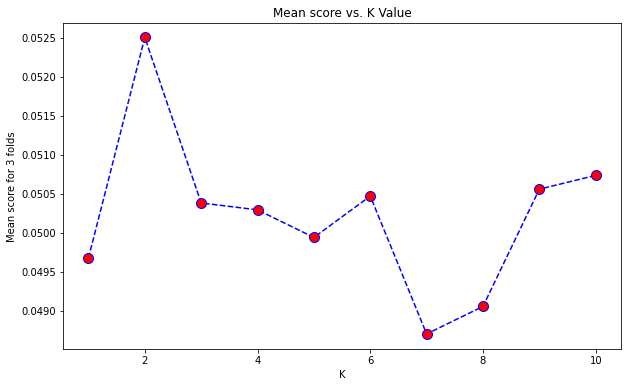

In [33]:
# 3. both
plot_optimal_kvalue(tfidf_data_vectorized, target, metric="cosine")


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [34]:
newsgroups = fetch_20newsgroups(
    subset="test", remove=["headers", "footers", "quotes"]
)

test_data = newsgroups["data"]
test_target = newsgroups["target"]


Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [35]:
# best model parameters: n_neighbors = 1, tfidf_vectorization and minkowski metric
tfidf_vectorizer = TfidfVectorizer()
test_tfidf_data_vectorized = tfidf_vectorizer.fit_transform(test_data).toarray()

clf = MyKNeighborsClassifier(n_neighbors=1)
scores = np.asarray([])
for train_index, test_index in kfold.split(test_tfidf_data_vectorized):
    clf.fit(test_tfidf_data_vectorized[train_index], test_target[train_index])
    pred = clf.predict(test_tfidf_data_vectorized[test_index])
    cur_score = accuracy_score(test_target[test_index], pred)
    # print(cur_score)
    scores = np.append(scores, cur_score)
mean_cur_score = np.mean(scores)
print(f"Mean score for 3 folds is {mean_cur_score}")


Mean score for 3 folds is 0.13435968061908743


Точность на тесте немного отличается в худшую сторону, что в целом ожидаемо и вполне нормально для любого алгоритма обучения